# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [55]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master('local') \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')


**Structure of the dataframe:**

In [4]:
len(df.columns)

18

In [96]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [5]:
df.count()

286500

The dataframe consists of 18 columns and 286500 rows. 

In [6]:
# check for missing values
nulls = df.select([f.count(f.when(f.isnull(col), col)).alias(col) for col in df.columns]).toPandas()

# reference:
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe?rq=1

In [103]:
# number of missing values in each column
nulls

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


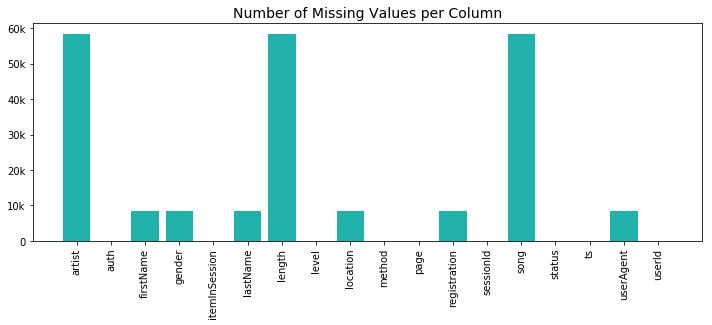

In [8]:
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(nulls.columns)), nulls.values[0], color='#20B2AA')
plt.xticks(np.arange(len(nulls.columns)), nulls.columns, rotation='vertical')
plt.yticks(np.arange(0, 61000, 10000), ['0','10k','20k','30k','40k','50k','60k'])
plt.title('Number of Missing Values per Column', fontsize=14);

The columns ***artist***, ***length***, and ***song*** have the same number of missing values. These probably refer to the records where the user was using the service but not listening to a song, so there is no information on the artist, song or length.

The columns ***firstName***, ***gender***, ***lastName***, ***location***, ***registration***, and ***userAgent*** have the exact same number of missing values as well. These records probably refer to the users that use the service but are not registered yet, or they are not logged in.


**Checking for invalid data:**

In [9]:
df.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [10]:
df_valid = df.filter(df.userId != "")
df_valid.count()

278154

In [11]:
df.count() - df_valid.count()

8346

Dropped 8346 rows with empty strings at userId. 

In [105]:
# check missing values again after dropping empty user ids
nulls = df_valid.select([f.count(f.when(f.isnull(col), col)).alias(col) for col in df_valid.columns]).toPandas()

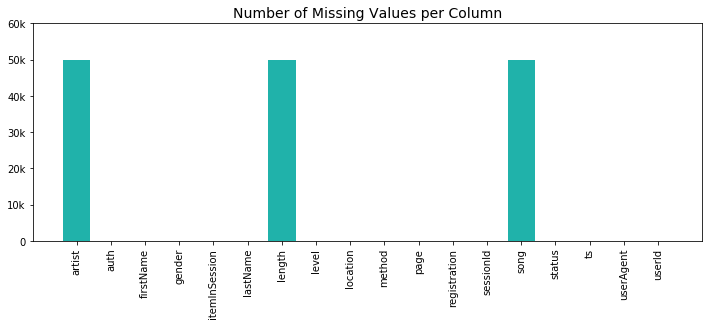

In [106]:
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(nulls.columns)), nulls.values[0], color='#20B2AA')
plt.xticks(np.arange(len(nulls.columns)), nulls.columns, rotation='vertical')
plt.yticks(np.arange(0, 61000, 10000), ['0','10k','20k','30k','40k','50k','60k'])
plt.title('Number of Missing Values per Column after dropping empty userID', fontsize=14);

After dropping the empty user-IDs there are missing values remaining among the sessions where no song was played. These are ok and don't need to be removed from the data. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [12]:
df_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Pages of interest for defining churn are "Cancel" and "Cancellation Confirmation". 

Check how often each page was visited:

In [13]:
df_valid.groupBy("page").count().sort("page").show()

+--------------------+------+
|                page| count|
+--------------------+------+
|               About|   495|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|              Cancel|    52|
|Cancellation Conf...|    52|
|           Downgrade|  2055|
|               Error|   252|
|                Help|  1454|
|                Home| 10082|
|              Logout|  3226|
|            NextSong|228108|
|         Roll Advert|  3933|
|       Save Settings|   310|
|            Settings|  1514|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|         Thumbs Down|  2546|
|           Thumbs Up| 12551|
|             Upgrade|   499|
+--------------------+------+



In [14]:
df_valid.agg(f.countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



The number of users cancelling the service is 52, while the total number of users in the dataset is 225. The classes are imbalanced but not too imbalanced for a proper try of predicting churn, where churn is someone reaching the "Cancellation Confirmation" page.

I will flag users that cancelled in a new column called "churn" (churned = 1, not churned = 0).

In [15]:
# find all users that cancelled
users_cancelled = df_valid.filter(df_valid.page == "Cancellation Confirmation").select("userId").dropDuplicates()

In [16]:
# should be 52 users
users_cancelled.count()

52

In [17]:
# list after the above query (not working properly)
users_cancelled.collect()

[Row(userId='125'),
 Row(userId='51'),
 Row(userId='54'),
 Row(userId='100014'),
 Row(userId='101'),
 Row(userId='29'),
 Row(userId='100021'),
 Row(userId='87'),
 Row(userId='73'),
 Row(userId='3'),
 Row(userId='28'),
 Row(userId='100022'),
 Row(userId='100025'),
 Row(userId='300007'),
 Row(userId='100006'),
 Row(userId='18'),
 Row(userId='70'),
 Row(userId='100005'),
 Row(userId='17'),
 Row(userId='100007'),
 Row(userId='300001'),
 Row(userId='100009'),
 Row(userId='100015'),
 Row(userId='200024'),
 Row(userId='100003'),
 Row(userId='103'),
 Row(userId='100024'),
 Row(userId='53'),
 Row(userId='122'),
 Row(userId='200017'),
 Row(userId='58'),
 Row(userId='100011'),
 Row(userId='100019'),
 Row(userId='100012'),
 Row(userId='200018'),
 Row(userId='200016'),
 Row(userId='200020'),
 Row(userId='106'),
 Row(userId='143'),
 Row(userId='32'),
 Row(userId='200001'),
 Row(userId='105'),
 Row(userId='200011'),
 Row(userId='100023'),
 Row(userId='100013'),
 Row(userId='100017'),
 Row(userId='121

In [18]:
# create new list that holds all users who cancelled the service 
users_cancelled = df_valid.filter(df_valid.page == 'Cancellation Confirmation')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x :    x)\ # without this the list is not callable in the next step
                                            .collect()

# reference:
# https://stackoverflow.com/questions/22350722/what-is-the-difference-between-map-and-flatmap-and-a-good-use-case-for-each

In [19]:
# now the list is flattened and callable in the following section
users_cancelled

['125',
 '51',
 '54',
 '100014',
 '101',
 '29',
 '100021',
 '87',
 '73',
 '3',
 '28',
 '100022',
 '100025',
 '300007',
 '100006',
 '18',
 '70',
 '100005',
 '17',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '103',
 '100024',
 '53',
 '122',
 '200017',
 '58',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '106',
 '143',
 '32',
 '200001',
 '105',
 '200011',
 '100023',
 '100013',
 '100017',
 '121',
 '12',
 '200015',
 '129',
 '200021',
 '100001']

In [20]:
# create churn column
df_valid_churn = df_valid.withColumn('churn', f.when(f.col("userId").isin(users_cancelled), 1).otherwise(0))

In [21]:
df_valid_churn.groupBy("churn").count().sort("churn").show()

+-----+------+
|churn| count|
+-----+------+
|    0|233290|
|    1| 44864|
+-----+------+



In [22]:
# test if it worked correctly --> there were 52 unique users visiting the "Cancellation Confirmation" page
df_valid_churn.filter(df_valid_churn.churn == 1).select("userId").dropDuplicates().count()

52

In [23]:
# do these 52 users account for 44864 rows in the data? (as the table above suggests)
df_valid_churn.filter(df_valid_churn.churn == 1).select("userId").count()

44864

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**Convert the unix timestamp to a common timestamp:**

In [24]:
df_valid_churn.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [25]:
get_timestamp = udf(lambda x: dt.datetime.fromtimestamp((x/1000)).strftime('%Y-%m-%d %H:%M:%S'))

# reference
# https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date

In [26]:
df_valid_churn = df_valid_churn.withColumn('time', get_timestamp(df_valid_churn["ts"]))

In [27]:
df_valid_churn.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, time='2018-10-01 00:01:57')

**Explore different columns with churn vs. no churn:**

In [28]:
df_valid_churn.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn',
 'time']

In [29]:
# grab some columns for visualizations
viz_data = df_valid_churn.select(["userId","churn","gender","level"]).toPandas()

In [30]:
# drop duplicate userIds (visuals should be on user and not record level)
viz_data.drop_duplicates(subset="userId", inplace=True)

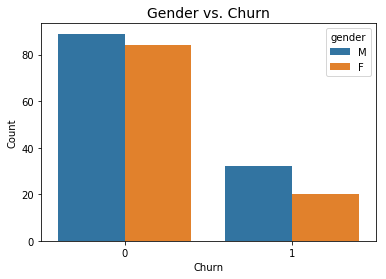

In [97]:
sns.countplot(x="churn", hue="gender", data=viz_data)
plt.title('Gender vs. Churn', fontsize=14)
plt.xlabel('Churn')
plt.ylabel('Count');
#plt.savefig('gender_churn.png', dpi=400);

- there are more male than female users
- among the users that churned are comparatively more males than females

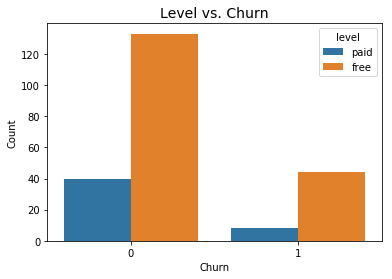

In [102]:
sns.countplot(x="churn", hue="level", data=viz_data)
plt.title('Level vs. Churn', fontsize=14)
plt.xlabel('Churn')
plt.ylabel('Count');
#plt.savefig('level_churn.png', dpi=400);

- there are a lot more users with a free account than with a paid account
- the ratio of free/paid accounts does not seem to be noticeably different between churned and not churned users, in both groups there are more free than paid accounts

Other features would also be interesting for the exploration, but I will create them in the following section and explore them after.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

How to create new features:

Since I want to make predictions on user-level later on, I also need features on the user-level. That means for the machine learning part I don't need the dataframe with multiple rows for each user, I rather need a dataframe with one row for each user and a number of different features that were extracted or calculated from the original dataframe. 

**Potential features:**
- Number of songs a user has listened to
- Total length of all sessions per user
- Number of different artists a user has listened to
- average length of session per user
- gender


**Number of artists a user has listened to:**

In [33]:
df_valid_churn.groupby("userId").agg(f.countDistinct("artist").alias("artist_count")).sort("userId").show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|    10|         565|
|   100|        1705|
|100001|         125|
|100002|         184|
|100003|          50|
+------+------------+
only showing top 5 rows



In [34]:
num_artists = df_valid_churn.groupby("userId").agg(f.countDistinct("artist").alias("artist_count")).sort("userId")

**Number of songs a user has listened to:**

In [35]:
df_valid_churn.groupby("userId").agg(f.countDistinct("song").alias("song_count")).sort("userId").show(5)

+------+----------+
|userId|song_count|
+------+----------+
|    10|       629|
|   100|      2302|
|100001|       129|
|100002|       193|
|100003|        51|
+------+----------+
only showing top 5 rows



In [36]:
num_songs = df_valid_churn.groupby("userId").agg(f.countDistinct("song").alias("song_count")).sort("userId")

**Total length of all sessions per user:**

In [37]:
df_valid_churn.groupby("userId").agg(f.sum("length").alias("total_length")).sort("userId").show(5)

+------+------------------+
|userId|      total_length|
+------+------------------+
|    10|166866.37251000004|
|   100|  672877.856590001|
|100001|35073.742150000005|
|100002| 49559.91809999999|
|100003|12306.419320000003|
+------+------------------+
only showing top 5 rows



In [38]:
length_sessions = df_valid_churn.groupby("userId").agg(f.sum("length").alias("total_length")).sort("userId")

**Average length of session per user:**

In [39]:
df_valid_churn.groupby("userId").agg(f.avg("length").alias("avg_length")).sort("userId").show(5)

+------+------------------+
|userId|        avg_length|
+------+------------------+
|    10|247.94408991084703|
|   100|250.88659828113387|
|100001|263.71234699248123|
|100002|254.15342615384608|
|100003|241.30233960784318|
+------+------------------+
only showing top 5 rows



In [40]:
avg_length = df_valid_churn.groupby("userId").agg(f.avg("length").alias("avg_length")).sort("userId")

**Combine all features with the dataframe (only unique users!):**

I will be using the gender feature from the original dataframe.

In [68]:
df_feat = df_valid_churn.select(["userId","gender","churn"]).dropDuplicates().sort("userId")

In [69]:
df_feat.count()

225

Dataframes to join:
- num_artists
- num_songs
- length_sessions
- avg_length

In [43]:
# join all dataframes
# num_artists
df_model = df_feat.join(num_artists, df_feat.userId == num_artists.userId).drop(num_artists.userId)
# num_songs
df_model = df_model.join(num_songs, df_model.userId == num_songs.userId).drop(num_songs.userId)
# length_sessions
df_model = df_model.join(length_sessions, df_model.userId == length_sessions.userId).drop(length_sessions.userId)
# avg_length
df_model = df_model.join(avg_length, df_model.userId == avg_length.userId).drop(avg_length.userId)

In [44]:
df_model.head()

Row(gender='F', churn=0, userId='100010', artist_count=252, song_count=269, total_length=66940.89735000003, avg_length=243.421444909091)

In [45]:
df_model.columns

['gender',
 'churn',
 'userId',
 'artist_count',
 'song_count',
 'total_length',
 'avg_length']

**Scale numeric features (artist_count, song_count, total_length, avg_length) and make gender numeric (0 and 1):**

In [46]:
# make vector from numeric features
assembler = VectorAssembler(inputCols=["artist_count","song_count","total_length","avg_length"], outputCol="NumFeatures")
df_model = assembler.transform(df_model)

In [47]:
df_model.head()

Row(gender='F', churn=0, userId='100010', artist_count=252, song_count=269, total_length=66940.89735000003, avg_length=243.421444909091, NumFeatures=DenseVector([252.0, 269.0, 66940.8974, 243.4214]))

In [48]:
# scale numeric features
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scaler_model = scaler.fit(df_model)
df_model = scaler_model.transform(df_model)

In [49]:
df_model.head()

Row(gender='F', churn=0, userId='100010', artist_count=252, song_count=269, total_length=66940.89735000003, avg_length=243.421444909091, NumFeatures=DenseVector([252.0, 269.0, 66940.8974, 243.4214]), ScaledNumFeatures=DenseVector([0.4173, 0.3001, 0.2431, 40.9675]))

In [50]:
# make gender column numeric
df_model = df_model.withColumn('genderDummy', f.when(df_model.gender == "M", 1).otherwise(0))

In [51]:
df_model.head()

Row(gender='F', churn=0, userId='100010', artist_count=252, song_count=269, total_length=66940.89735000003, avg_length=243.421444909091, NumFeatures=DenseVector([252.0, 269.0, 66940.8974, 243.4214]), ScaledNumFeatures=DenseVector([0.4173, 0.3001, 0.2431, 40.9675]), genderDummy=0)

In [52]:
# assemble all features into one vector
assembler = VectorAssembler(inputCols=["ScaledNumFeatures","genderDummy"], outputCol="features")
df_model = assembler.transform(df_model)

In [100]:
df_model.head()

Row(gender='F', churn=0, userId='100010', artist_count=252, song_count=269, total_length=66940.89735000003, avg_length=243.421444909091, NumFeatures=DenseVector([252.0, 269.0, 66940.8974, 243.4214]), ScaledNumFeatures=DenseVector([0.4173, 0.3001, 0.2431, 40.9675]), genderDummy=0, features=DenseVector([0.4173, 0.3001, 0.2431, 40.9675, 0.0]))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [53]:
# select final dataframe only containing features and label columns
df_final = df_model.select(df_model.churn.alias("label"), df_model.features)
df_final.persist()

DataFrame[label: int, features: vector]

In [54]:
df_final.head()

Row(label=0, features=DenseVector([0.4173, 0.3001, 0.2431, 40.9675, 0.0]))

In [57]:
# split dataframe
train, test = df_final.randomSplit([0.75, 0.25], seed=42)
train.persist()

DataFrame[label: int, features: vector]

### Logistic Regression

In [59]:
# default metric is f1 score
MulticlassClassificationEvaluator().getMetricName()

'f1'

In [60]:
lr = LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50]) \
    .addGrid(lr.regParam, [0.01, 0.1, 0.2]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(), # f1
                          numFolds=3)

In [61]:
# training
cv_lr = crossval.fit(train)

In [71]:
# save the best model for later use
cv_lr.bestModel.save('best_cv_lr_2906.model')

In [64]:
# f1 score for all six models that were trained during cross validation
cv_lr.avgMetrics

[0.6778065552204722,
 0.6778065552204722,
 0.6778065552204722,
 0.6778065552204722,
 0.6778065552204722,
 0.6778065552204722]

In [72]:
results = cv_lr.bestModel.transform(test)

In [74]:
results.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.56130300594458...|[0.90076180297419...|[0.71110602820879...|       0.0|
|    0|[3.69565872940505...|[2.36744709285480...|[0.91431106105803...|       0.0|
|    0|[2.15580092548628...|[1.35884067478815...|[0.79557121238620...|       0.0|
|    0|[0.32287341049909...|[0.84186039118543...|[0.69885689116024...|       0.0|
|    0|[3.43239271776733...|[2.24831560876875...|[0.90450514391286...|       0.0|
|    1|[0.32618493265806...|[0.84238026830338...|[0.69896629107378...|       0.0|
|    0|[0.08775533721257...|[0.78492482161606...|[0.68674055389816...|       0.0|
|    0|[0.55302420054717...|[0.89877453725047...|[0.71069760456650...|       0.0|
|    0|[0.04636131022551...|[1.23867718369899...|[0.77533367501557...|       0.0|
|    1|[0.918947

In [89]:
evaluator = MulticlassClassificationEvaluator()
f1_score_lr = evaluator.evaluate(results)
print("F1 Score Logistic Regression: {}".format(f1_score_lr))

F1 Score Logistic Regression: 0.6357031655422937


### Random Forest Classifier

In [90]:
rf = RandomForestClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 25]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [91]:
cv_rf = crossval.fit(train)

In [92]:
cv_rf.bestModel.save('best_cv_rf_2906.model')

In [93]:
# f1 score for all six models that were trained during cross validation
cv_rf.avgMetrics

[0.6765302352912576,
 0.6733436651086904,
 0.6689183309317299,
 0.6764787402984709,
 0.6739488257671948,
 0.671110541938812]

In [94]:
results = cv_rf.bestModel.transform(test)

In [99]:
evaluator = MulticlassClassificationEvaluator()
f1_score_rf = evaluator.evaluate(results)
print("F1 Score Random Forest Classifier: {}".format(f1_score_rf))

F1 Score Random Forest Classifier: 0.6694528875379939


The best model out of the2 I tried is the random forest classifier. It correctly predicts churn in 66.9% of the cases in the test data. 

In [124]:
cv_rf.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_202e08fdc4d0) with 50 trees

In [127]:
cv_rf.bestModel.params

[Param(parent='RandomForestClassifier_202e08fdc4d0', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'),
 Param(parent='RandomForestClassifier_202e08fdc4d0', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'),
 Param(parent='RandomForestClassifier_202e08fdc4d0', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'),
 Param(parent='RandomForestClassifier_202e08fdc4d0', name='featuresCol', doc='features column name'),
 Param(parent='RandomForestClassifier_202e08fdc4d0', name='impurity', doc='Criterion

In [128]:
cv_rf.bestModel.treeWeights

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

The final model is the random forest classifier with 50 trees. All trees are weighted the same.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.